In [1]:
%pylab inline
import pandas as pd
import dask.dataframe as dd

Populating the interactive namespace from numpy and matplotlib


In [2]:
import dask.array as da
import datetime 
import gc
from multiprocessing import pool
import cPickle as pickle
import os

In [3]:
sample=pd.read_csv("../input/sample_submission.csv")

In [4]:
sample.shape

(9463187, 5)

In [5]:
parcelids=sample['ParcelId'].values
len(parcelids)

9463187

In [6]:
df=dd.read_parquet("../input/home_attributes_history/home_attributes_2017_v1.parq")[['parcelid','rawcensustractandblock']] 
df['state']=df['rawcensustractandblock'].map(lambda u: str(u)[:2])
df=df.drop('rawcensustractandblock',axis=1).compute()
df=df.set_index('parcelid')
df.shape

(9463187, 1)

In [7]:
df['state'].value_counts()

39    3111391
37    2932874
06    1809321
36     829379
19     732280
na      47942
Name: state, dtype: int64

In [8]:
df=df[df['state']=='36']
df.shape

(829379, 1)

In [9]:
filename='tax_history_2007to2017_v2.parq'

In [10]:
data=dd.read_parquet("../input/"+filename).drop(
    ['landappraisedvalue','improvementappraisedvalue','taxdelinquencyamount','totalappraisedvalue'],axis=1
).compute().set_index("parcelid")

In [11]:
print data.shape
data=data.loc[df.index]
print data.shape

(84932226, 14)
(6797647, 14)


In [1]:
#set(data.assessmentyear)

In [13]:
years=[2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]

In [14]:
data_dict={u:data[data['assessmentyear']==u] for u in 
           years}

In [15]:
for i in years:
    print i, data_dict[i].shape[0]

2007 438108
2008 665652
2009 793292
2010 802193
2011 809677
2012 814459
2013 817155
2014 0
2015 827732
2016 829287
2017 0


In [16]:
lst=[]
for i in years:
    lst.append(data_dict[i].isnull().mean())
tmpdf=pd.concat(lst,axis=1)
tmpdf.columns=years
tmpdf

/home/bo/anaconda2/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


2007      2008      2009      2010      2011  \
assessmentyear              0.000000  0.000000  0.000000  0.000000  0.000000   
taxratecodearea             1.000000  1.000000  1.000000  1.000000  1.000000   
improvementmarketvalue      0.004839  0.003132  0.002975  0.002690  0.002386   
structuretaxvaluedollarcnt  0.004839  0.003132  0.002975  0.002690  0.002384   
totalassessedvalue          0.000623  0.000054  0.000030  0.000040  0.000031   
taxamount                   1.000000  1.000000  1.000000  1.000000  1.000000   
taxvaluedollarcnt           0.000623  0.000054  0.000030  0.000040  0.000031   
edition                     0.000000  0.000000  0.000000  0.000000  0.000000   
landassessedvalue           0.000623  0.000054  0.000030  0.000041  0.000032   
taxdelinquencyyear          1.000000  1.000000  1.000000  1.000000  1.000000   
totalmarketvalue            0.000623  0.000054  0.000030  0.000040  0.000033   
improvementassessedvalue    0.004839  0.003132  0.002975  0.002701  0.002384   
landtaxvaluedollarcnt       0.000623  0.000054  0.000030  0.000040  0.000031   
landmarketvalue             0.000623  0.000054  0.000030  0.000040  0.000033   

                                2012      2013  2014      2015      2016  2017  
assessmentyear              0.000000  0.000000   NaN  0.000000  0.000000   NaN  
taxratecodearea             1.000000  1.000000   NaN  1.000000  1.000000   NaN  
improvementmarketvalue      0.002351  0.001937   NaN  0.001520  0.000945   NaN  
structuretaxvaluedollarcnt  0.002351  0.001937   NaN  0.001520  0.000945   NaN  
totalassessedvalue          0.000021  0.000009   NaN  0.000001  0.000340   NaN  
taxamount                   1.000000  1.000000   NaN  0.011574  0.011721   NaN  
taxvaluedollarcnt           0.000021  0.000009   NaN  0.000001  0.000340   NaN  
edition                     0.000000  0.000000   NaN  0.000000  0.000000   NaN  
landassessedvalue           0.000022  0.000010   NaN  0.000002  0.000341   NaN  
taxdelinquencyyear          1.000000  0.000000   NaN  1.000000  1.000000   NaN  
totalmarketvalue            0.000021  0.000009   NaN  0.000001  0.000340   NaN  
improvementassessedvalue    0.002351  0.001938   NaN  0.001520  0.000945   NaN  
landtaxvaluedollarcnt       0.000021  0.000009   NaN  0.000001  0.000340   NaN  
landmarketvalue             0.000021  0.000009   NaN  0.000001  0.000340   NaN

In [17]:
def get_col(col):
    df=pd.concat([data_dict[i][col] for i in years],axis=1)
    df.columns=years
    return df

In [18]:
print "Are there ones whose tax is not null but taxvalue is null?"
a=get_col("taxamount")
b=get_col("taxvaluedollarcnt")

Are there ones whose tax is not null but taxvalue is null?


In [19]:
for year in years:
    aa=a.loc[:,year]
    bb=b.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    num=np.sum((~ab.iloc[:,0].isnull()) & ab.iloc[:,1].isnull())
    print year,num,ab.shape[0],float(num)/ab.shape[0]
    #break

2007 0 829287 0.0
2008 0 829287 0.0
2009 0 829287 0.0
2010 0 829287 0.0
2011 0 829287 0.0
2012 0 829287 0.0
2013 0 829287 0.0
2014 0 829287 0.0
2015 0 829287 0.0
2016 0 829287 0.0
2017 0 829287 0.0


In [20]:
print "how assesed values varies with market value?"
c=get_col('totalassessedvalue')
d=get_col('totalmarketvalue')

how assesed values varies with market value?


In [23]:
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    n1=np.sum((~ab.iloc[:,0].isnull()) & ab.iloc[:,1].isnull())
   
    n2=np.sum((ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull())
    n3=np.sum((~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull())
    n4=data_dict[year].shape[0]
    if n4<1: 
        print year, 'missing'
        continue     
    print year,n1,n2,n3,n4,np.round([float(n1)/n4,float(n2)/n4,float(n3)/n4,float(n4-n1-n2-n3)/n4],3)

2007 0 0 437835 438108 [ 0.     0.     0.999  0.001]
2008 0 0 665616 665652 [ 0.  0.  1.  0.]
2009 0 0 793268 793292 [ 0.  0.  1.  0.]
2010 0 0 802161 802193 [ 0.  0.  1.  0.]
2011 2 0 809650 809677 [ 0.  0.  1.  0.]
2012 0 0 814442 814459 [ 0.  0.  1.  0.]
2013 0 0 817148 817155 [ 0.  0.  1.  0.]
2014 missing
2015 0 0 827731 827732 [ 0.  0.  1.  0.]
2016 0 0 829005 829287 [ 0.  0.  1.  0.]
2017 missing


In [28]:
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    ind=(~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull()
    n1=np.sum(ind)
    if n1<1: 
        print year, 'missing'
        continue
    n2=np.sum( ind & (ab.iloc[:,0]>ab.iloc[:,1]))
    n3=np.sum( ind & (ab.iloc[:,0]<ab.iloc[:,1]))
    ne=np.sum( ind & (ab.iloc[:,0]==ab.iloc[:,1]))
    n4=data_dict[year].shape[0]
    
    print year,n1,n2,n3,n4,np.round([float(n1)/n4,float(n2)/n1,float(n3)/n1,float(ne)/n1],3) 
    

2007 437835 0 437835 438108 [ 0.999  0.     1.     0.   ]
2008 665616 0 665616 665652 [ 1.  0.  1.  0.]
2009 793268 0 793268 793292 [ 1.  0.  1.  0.]
2010 802161 0 802161 802193 [ 1.  0.  1.  0.]
2011 809650 0 809650 809677 [ 1.  0.  1.  0.]
2012 814442 36 814406 814459 [ 1.  0.  1.  0.]
2013 817148 34 817114 817155 [ 1.  0.  1.  0.]
2014 missing
2015 827731 4 827727 827732 [ 1.  0.  1.  0.]
2016 829005 3 829002 829287 [ 1.  0.  1.  0.]
2017 missing


In [29]:
print """
    almost always less  
"""


    almost always less  



look at their difference
2007 437835 437835 [ 0.999  1.   ]


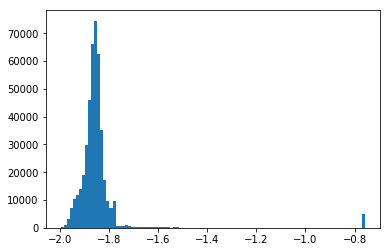

2008 665616 665616 [ 1.  1.]


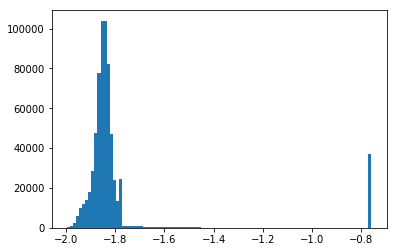

2009 793268 793268 [ 1.  1.]


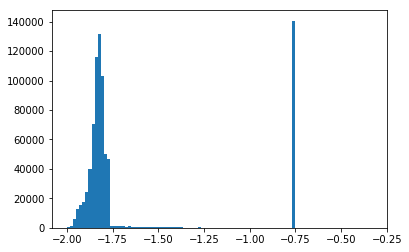

2010 802161 802161 [ 1.  1.]


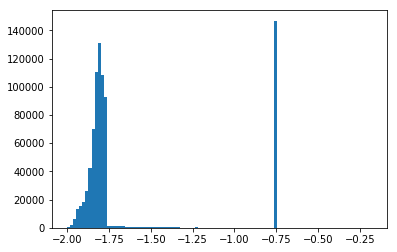

2011 809650 809650 [ 1.  1.]


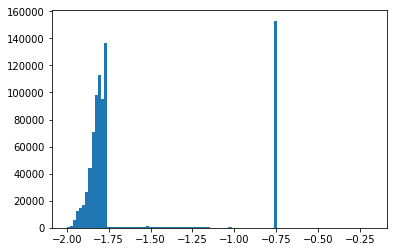

2012 814442 814442 [ 1.  1.]


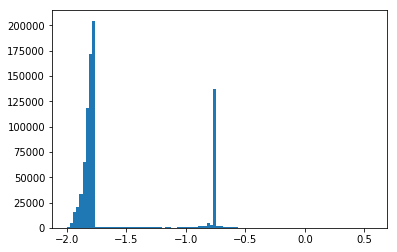

2013 817148 817148 [ 1.  1.]


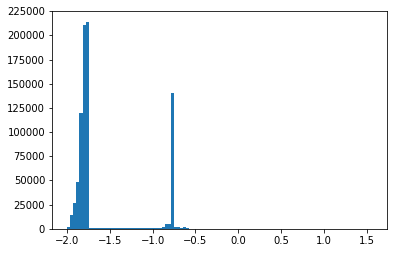

2014 missing
2015 827731 827731 [ 1.  1.]


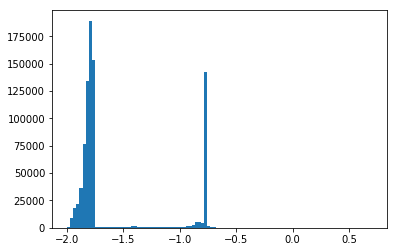

2016 829005 829005 [ 1.  1.]


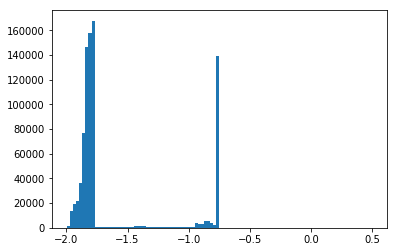

2017 missing


In [30]:
print "look at their difference"
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    ind=(~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull()
    n1=np.sum(ind)
    if n1<1: 
        print year, 'missing'
        continue    
    ind2= ( ind & (ab.iloc[:,0]<>ab.iloc[:,1]))
    n2=np.sum(ind2)
    n4=data_dict[year].shape[0]
    print year,n1,n2,np.round([float(n1)/n4,float(n2)/n1],3) 
    difference=2*(aa[ind2]-bb[ind2])/(aa[ind2]+bb[ind2])
    plt.hist(difference,bins=100);plt.show()
    #break

In [31]:
print """
    big difference
"""


    big difference



### landassessedvalue vs  landmarketvalue

In [32]:
print "how assesed values varies with market value?"
c=get_col('landassessedvalue')
d=get_col('landmarketvalue')

how assesed values varies with market value?


In [34]:
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    n1=np.sum((~ab.iloc[:,0].isnull()) & ab.iloc[:,1].isnull())
    n2=np.sum((ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull())
    n3=np.sum((~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull())
    n4=data_dict[year].shape[0]
    if n4<1: 
        print year, 'missing'
        continue     
    print year,n1,n2,n3,n4,np.round([float(n1)/n4,float(n2)/n4,float(n3)/n4,float(n4-n1-n2-n3)/n4],3)

 2007 0 0 437835 438108 [ 0.     0.     0.999  0.001]
2008 0 0 665616 665652 [ 0.  0.  1.  0.]
2009 0 0 793268 793292 [ 0.  0.  1.  0.]
2010 0 1 802160 802193 [ 0.  0.  1.  0.]
2011 2 1 809649 809677 [ 0.  0.  1.  0.]
2012 0 1 814441 814459 [ 0.  0.  1.  0.]
2013 0 1 817147 817155 [ 0.  0.  1.  0.]
2014 missing
2015 0 1 827730 827732 [ 0.  0.  1.  0.]
2016 0 1 829004 829287 [ 0.  0.  1.  0.]
2017 missing


In [35]:
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    ind=(~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull()
    n1=np.sum(ind)
    if n1<1: 
        print year, 'missing'
        continue        
    n2=np.sum( ind & (ab.iloc[:,0]>ab.iloc[:,1]))
    n3=np.sum( ind & (ab.iloc[:,0]<ab.iloc[:,1]))
    ne=np.sum( ind & (ab.iloc[:,0]==ab.iloc[:,1]))
    n4=data_dict[year].shape[0]
    
    print year,n1,n2,n3,n4,np.round([float(n1)/n4,float(n2)/n1,float(n3)/n1,float(ne)/n1],3) 

2007 437835 0 437835 438108 [ 0.999  0.     1.     0.   ]
2008 665616 0 665616 665652 [ 1.  0.  1.  0.]
2009 793268 0 793268 793292 [ 1.  0.  1.  0.]
2010 802160 0 802160 802193 [ 1.  0.  1.  0.]
2011 809649 0 809649 809677 [ 1.  0.  1.  0.]
2012 814441 240 814201 814459 [ 1.  0.  1.  0.]
2013 817147 169 816978 817155 [ 1.  0.  1.  0.]
2014 missing
2015 827730 58 827672 827732 [ 1.  0.  1.  0.]
2016 829004 49 828955 829287 [ 1.  0.  1.  0.]
2017 missing


In [36]:
print """
    always less 
"""


    always less 



look at their difference
2007 437835 437835 [ 0.999  1.   ]


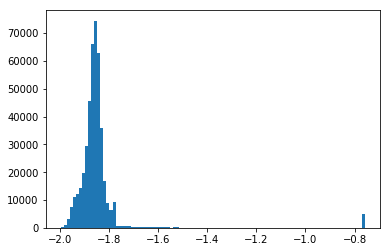

2008 665616 665616 [ 1.  1.]


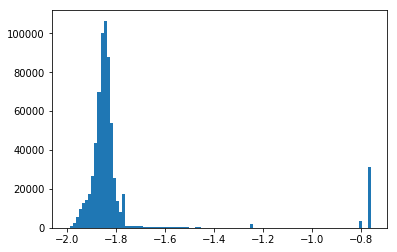

2009 793268 793268 [ 1.  1.]


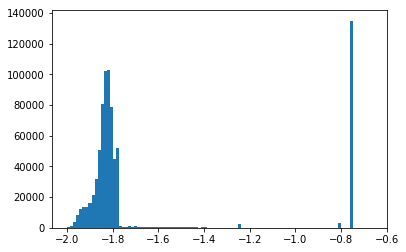

2010 802160 802160 [ 1.  1.]


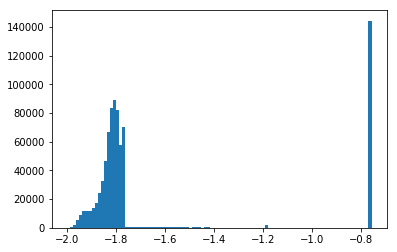

2011 809649 809649 [ 1.  1.]


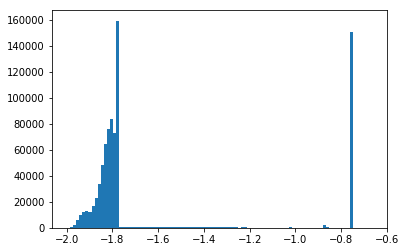

2012 814441 814441 [ 1.  1.]


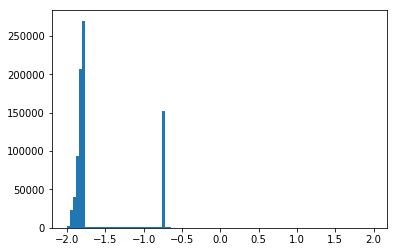

2013 817147 817147 [ 1.  1.]


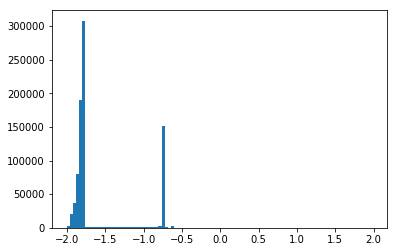

2014 missing
2015 827730 827730 [ 1.  1.]


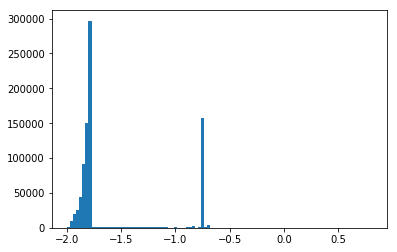

2016 829004 829004 [ 1.  1.]


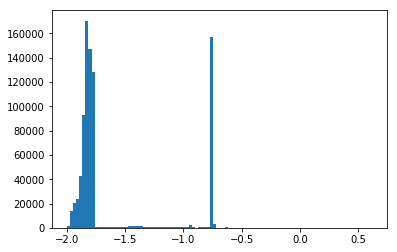

2017 missing


In [37]:
print "look at their difference"
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    ind=(~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull()
    n1=np.sum(ind)
    if n1<1: 
        print year, 'missing'
        continue        
    ind2= ( ind & (ab.iloc[:,0]<>ab.iloc[:,1]))
    n2=np.sum(ind2)
    n4=data_dict[year].shape[0]
    print year,n1,n2,np.round([float(n1)/n4,float(n2)/n1],3) 
    difference=2*(aa[ind2]-bb[ind2])/(aa[ind2]+bb[ind2])
    plt.hist(difference,bins=100);plt.show()
    #break

In [38]:
print """
    big difference
"""


    big difference



### landassessedvalue vs  landmarketvalue

In [39]:
print "how assesed values varies with market value?"
c=get_col('improvementassessedvalue')
d=get_col('improvementmarketvalue')

how assesed values varies with market value?


In [40]:
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    n1=np.sum((~ab.iloc[:,0].isnull()) & ab.iloc[:,1].isnull())
    n2=np.sum((ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull())
    n3=np.sum((~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull())
    n4=data_dict[year].shape[0]
    if n4<1: 
        print year, 'missing'
        continue    
    print year,n1,n2,n3,n4,np.round([float(n1)/n4,float(n2)/n4,float(n3)/n4,float(n4-n1-n2-n3)/n4],3)

2007 0 0 435988 438108 [ 0.     0.     0.995  0.005]
2008 0 0 663567 665652 [ 0.     0.     0.997  0.003]
2009 0 0 790932 793292 [ 0.     0.     0.997  0.003]
2010 0 9 800026 802193 [ 0.     0.     0.997  0.003]
2011 2 0 807745 809677 [ 0.     0.     0.998  0.002]
2012 0 0 812544 814459 [ 0.     0.     0.998  0.002]
2013 0 1 815571 817155 [ 0.     0.     0.998  0.002]
2014 missing
2015 0 0 826474 827732 [ 0.     0.     0.998  0.002]
2016 0 0 828503 829287 [ 0.     0.     0.999  0.001]
2017 missing


In [41]:
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    ind=(~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull()
    n1=np.sum(ind)
    if n1<1: 
        print year, 'missing'
        continue        
    n2=np.sum( ind & (ab.iloc[:,0]>ab.iloc[:,1]))
    n3=np.sum( ind & (ab.iloc[:,0]<ab.iloc[:,1]))
    ne=np.sum( ind & (ab.iloc[:,0]==ab.iloc[:,1]))
    n4=data_dict[year].shape[0]
    
    print year,n1,n2,n3,n4,np.round([float(n1)/n4,float(n2)/n1,float(n3)/n1,float(ne)/n1],3) 

2007 435988 0 435988 438108 [ 0.995  0.     1.     0.   ]
2008 663567 1 663566 665652 [ 0.997  0.     1.     0.   ]
2009 790932 2 790930 793292 [ 0.997  0.     1.     0.   ]
2010 800026 1 800024 802193 [ 0.997  0.     1.     0.   ]
2011 807745 30 807714 809677 [ 0.998  0.     1.     0.   ]
2012 812544 169 812374 814459 [ 0.998  0.     1.     0.   ]
2013 815571 68 815502 817155 [ 0.998  0.     1.     0.   ]
2014 missing
2015 826474 55 826418 827732 [ 0.998  0.     1.     0.   ]
2016 828503 13 828489 829287 [ 0.999  0.     1.     0.   ]
2017 missing


In [42]:
print """
    always less
"""


    always less



look at their difference
2007 435988 435988 [ 0.995  1.   ]


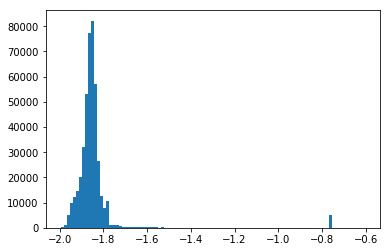

2008 663567 663567 [ 0.997  1.   ]


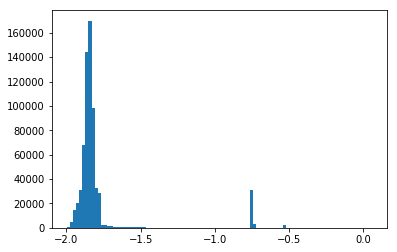

2009 790932 790932 [ 0.997  1.   ]


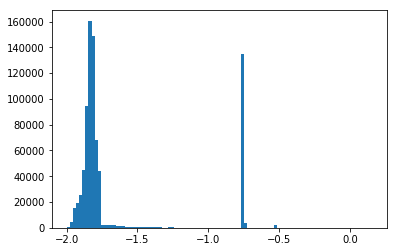

2010 800026 800025 [ 0.997  1.   ]


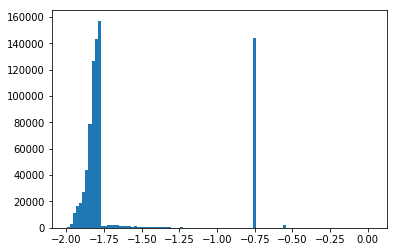

2011 807745 807744 [ 0.998  1.   ]


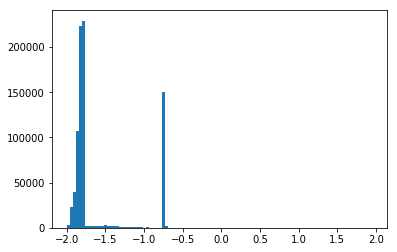

2012 812544 812543 [ 0.998  1.   ]


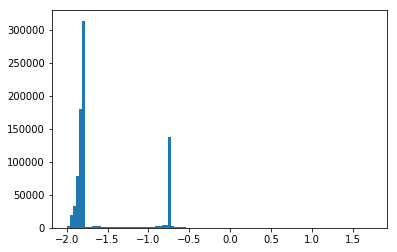

2013 815571 815570 [ 0.998  1.   ]


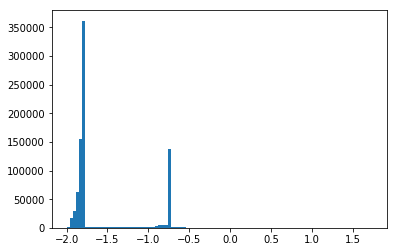

2014 missing
2015 826474 826473 [ 0.998  1.   ]


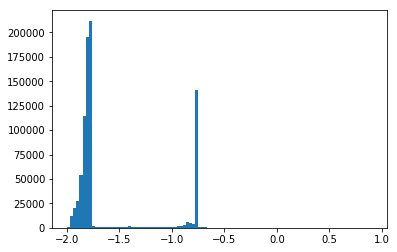

2016 828503 828502 [ 0.999  1.   ]


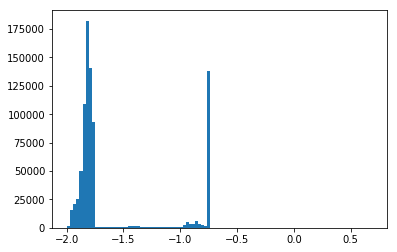

2017 missing


In [43]:
print "look at their difference"
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    ind=(~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull()
    n1=np.sum(ind)
    if n1<1: 
        print year, 'missing'
        continue        
    ind2= ( ind & (ab.iloc[:,0]<>ab.iloc[:,1]))
    n2=np.sum(ind2)
    n4=data_dict[year].shape[0]
    print year,n1,n2,np.round([float(n1)/n4,float(n2)/n1],3) 
    difference=2*(aa[ind2]-bb[ind2])/(aa[ind2]+bb[ind2])
    plt.hist(difference,bins=100);plt.show()
    #break

In [44]:
print """
   big diff
"""


   big diff



### land vs total

In [45]:
c=get_col('improvementassessedvalue')
d=get_col('landassessedvalue')

In [47]:
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    n1=np.sum((~ab.iloc[:,0].isnull()) & ab.iloc[:,1].isnull())
    n2=np.sum((ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull())
    n3=np.sum((~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull())
    n4=data_dict[year].shape[0]
    if n4<1: 
        print year, 'missing'
        continue    
    print year,n1,n2,n3,n4,np.round([float(n1)/n4,float(n2)/n4,float(n3)/n4,float(n4-n1-n2-n3)/n4],3)

2007 0 1847 435988 438108 [ 0.     0.004  0.995  0.001]
2008 0 2049 663567 665652 [ 0.     0.003  0.997  0.   ]
2009 0 2336 790932 793292 [ 0.     0.003  0.997  0.   ]
2010 1 2135 800025 802193 [ 0.     0.003  0.997  0.   ]
2011 1 1905 807746 809677 [ 0.     0.002  0.998  0.   ]
2012 1 1898 812543 814459 [ 0.     0.002  0.998  0.   ]
2013 1 1577 815570 817155 [ 0.     0.002  0.998  0.   ]
2014 missing
2015 1 1257 826473 827732 [ 0.     0.002  0.998  0.   ]
2016 1 502 828502 829287 [ 0.     0.001  0.999  0.   ]
2017 missing


In [48]:
print "most of them are null consistent   "

most of them are null consistent   


 look at their ratio
2007 435988 [ 0.995] 0.0 0.0


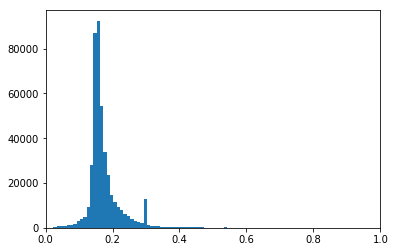

2008 663567 [ 0.997] 0.0 0.0


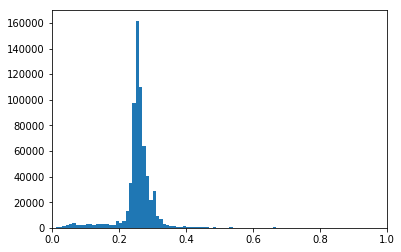

2009 790932 [ 0.997] 0.0 0.0


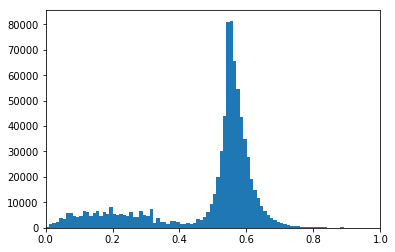

2010 800025 [ 0.997] 0.0 0.0


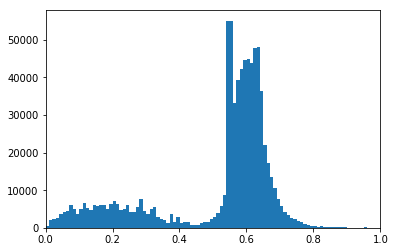

2011 807746 [ 0.998] 0.0 0.0


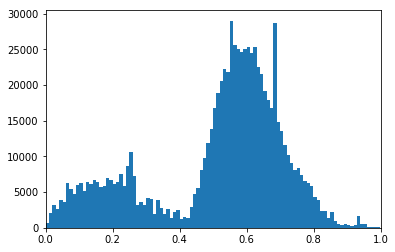

2012 812543 [ 0.998] 0.0 0.0


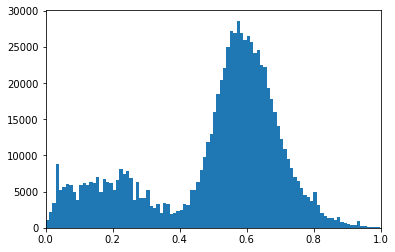

2013 815570 [ 0.998] 0.0 0.0


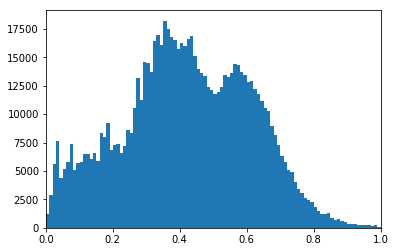

2014 missing
2015 826473 [ 0.998] 0.0 0.0


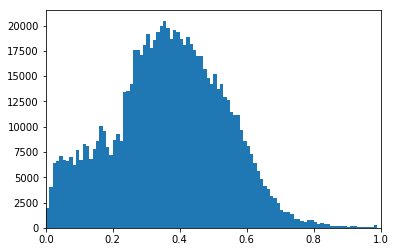

2016 828502 [ 0.999] 0.0 0.0


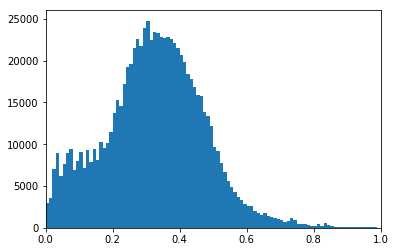

2017 missing


In [50]:
print "look at their ratio"
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    ind=(~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull()
    n1=np.sum(ind)
    if n1<1: 
        print year, 'missing'
        continue    
    n4=data_dict[year].shape[0]
    print year,n1,np.round([float(n1)/n4],3), np.mean(aa[ind]<=0), np.mean(bb[ind]<=0)
    ind2=ind & ((aa>0) & (bb>0))
    ratios=bb[ind2]/(bb[ind2]+aa[ind2])
    plt.hist(ratios,bins=100);xlim([0,1]);plt.show()
    #break

In [51]:
print """
    big changes
"""


    big changes



### land vs total

In [52]:
c=get_col(u'improvementmarketvalue')
d=get_col(u'landmarketvalue')

In [54]:
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    n1=np.sum((~ab.iloc[:,0].isnull()) & ab.iloc[:,1].isnull())
    n2=np.sum((ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull())
    n3=np.sum((~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull())
    n4=data_dict[year].shape[0]
    if n4<1: 
        print year, 'missing'
        continue       
    print year,n1,n2,n3,n4,np.round([float(n1)/n4,float(n2)/n4,float(n3)/n4,float(n4-n1-n2-n3)/n4],3)

 2007 0 1847 435988 438108 [ 0.     0.004  0.995  0.001]
2008 0 2049 663567 665652 [ 0.     0.003  0.997  0.   ]
2009 0 2336 790932 793292 [ 0.     0.003  0.997  0.   ]
2010 0 2126 800035 802193 [ 0.     0.003  0.997  0.   ]
2011 0 1905 807745 809677 [ 0.     0.002  0.998  0.   ]
2012 0 1898 812544 814459 [ 0.     0.002  0.998  0.   ]
2013 0 1576 815572 817155 [ 0.     0.002  0.998  0.   ]
2014 missing
2015 0 1257 826474 827732 [ 0.     0.002  0.998  0.   ]
2016 0 502 828503 829287 [ 0.     0.001  0.999  0.   ]
2017 missing


In [55]:
print "most of them are null consistent   "

most of them are null consistent   


 look at their ratio
2007 435988 [ 0.995] 0.0 0.0


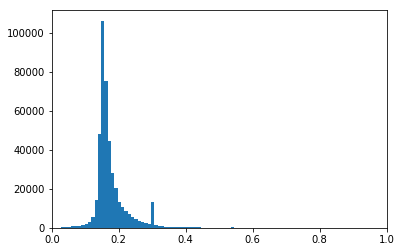

2008 663567 [ 0.997] 0.0 0.0


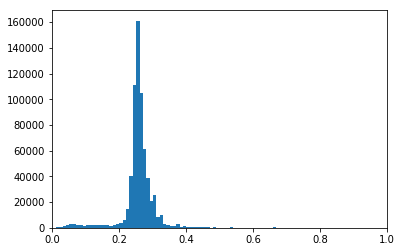

2009 790932 [ 0.997] 0.0 0.0


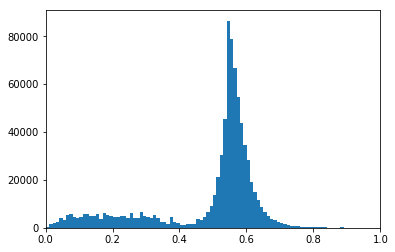

2010 800035 [ 0.997] 0.0 0.0


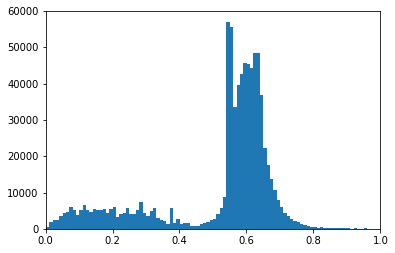

2011 807745 [ 0.998] 0.0 0.0


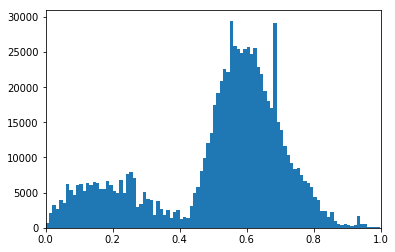

2012 812544 [ 0.998] 0.0 0.0


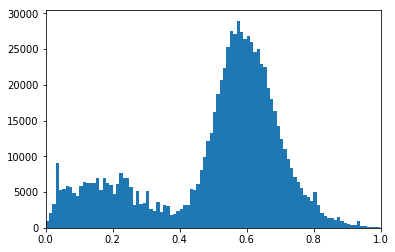

2013 815572 [ 0.998] 0.0 0.0


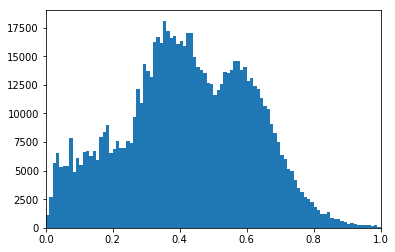

2014 missing
2015 826474 [ 0.998] 0.0 0.0


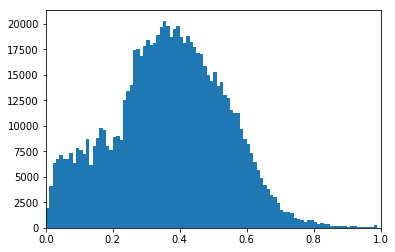

2016 828503 [ 0.999] 0.0 0.0


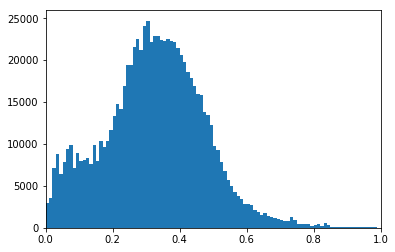

2017 missing


In [57]:
print "look at their ratio"
for year in years:
    aa=c.loc[:,year]
    bb=d.loc[:,year]
    ab=pd.concat([aa,bb],axis=1)
    ind=(~ab.iloc[:,0].isnull()) & ~ab.iloc[:,1].isnull()
    n1=np.sum(ind)
    if n1<1: 
        print year, 'missing'
        continue       
    n4=data_dict[year].shape[0]
    print year,n1,np.round([float(n1)/n4],3), np.mean(aa[ind]<=0), np.mean(bb[ind]<=0)
    ind2=ind & ((aa>0) & (bb>0))
    ratios=bb[ind2]/(bb[ind2]+aa[ind2])
    plt.hist(ratios,bins=100);xlim([0,1]);plt.show()
    #break

In [58]:
print """
    big changes
"""


    big changes

